- OneCycle
- augmentated TTA

# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0713B1'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.PRFX_PREP = 'MelPrp0909A224' 
param.ARCH = 'efficientnet-b0'

from efficientnet_pytorch import EfficientNet
param.SZ = 224 

param.EPOCHS = 10

param.BS = 72
param.SEED = 101; 

param.K=5; 
param.FLDS2USE = range(param.K)
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.USE_LAST_M_EPCS = 5

param.RandomResizedCrop_scale=(0.75, 1.0)
param.N_TTA = 20

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.N_TTA = 3
    param.EPOCHS = 2
    param.FLDS2USE = [0,1]
    param.N_SAMPL = 1024

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0713B1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909A224',
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'EPOCHS': 10,
 'BS': 72,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 20,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
!nvidia-smi

Tue Jul 14 01:38:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   45C    P0    54W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

import pretrainedmodels
# from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
if param.PRFX_B4 is not None: p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
23539,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_2618037,0.0
48725,19,../output/MelPrp0909A224/andrewmvd--isic-2019/...,BCN_0000529,0.0


(58032, 4)

20    32701
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017767
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 46425 11607
1 46425 11607
2 46426 11606
3 46426 11606
4 46426 11606


0.0    0.912159
1.0    0.087841
Name: target, dtype: float64

0.0    0.911922
1.0    0.088078
Name: target, dtype: float64

0.0    0.911903
1.0    0.088097
Name: target, dtype: float64

0.0    0.910697
1.0    0.089303
Name: target, dtype: float64

0.0    0.913648
1.0    0.086352
Name: target, dtype: float64

20    26172
19    20253
Name: source, dtype: int64

20    26147
19    20278
Name: source, dtype: int64

20    26171
19    20255
Name: source, dtype: int64

20    26137
19    20289
Name: source, dtype: int64

20    26177
19    20249
Name: source, dtype: int64

In [7]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
19    25331
Name: source, dtype: int64

32701

In [8]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

11607 6529
11607 6554
11606 6530
11606 6564
11606 6524


## testset

In [9]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909A224/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909A224/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909A224/siim-isic-melanoma-cl...


# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        self.composed = A.Compose([
            A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
            A.Transpose(),
            A.Flip(),
            A.Rotate(360),
            A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
            A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5),
            A.Normalize(), 
            AT.ToTensor(),
        ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode =='trn':
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [11]:
if param.DEBUG: 
    dstst = MelDataset(dftst, mode='tst')
    i = np.random.choice(len(dstst))
    print(dstst[i][0].shape)


In [12]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    plt.imshow(dstst[i][0].permute(1, 2, 0))

## test ds

In [13]:
dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

10982
77


# model

In [14]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [15]:
mdl = mkmdl()

Loaded pretrained weights for efficientnet-b0


## focal loss

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

# train

## TTA

In [17]:
# def evaluate(model, dl):
#     model.eval()
#     prd = []
#     y = []
#     for step, dat in enumerate(dl):
#         xb, yb = (o.to(device) for o in dat)
#         with torch.no_grad(): prdb = model(xb)
#         prd.append(prdb.cpu().detach().numpy())
#         y.append(yb.cpu().detach().numpy())
#     prd = np.concatenate(prd)    
#     y = np.concatenate(y)    
#     lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
#     scr = roc_auc(y, prd)
#     return lss, scr, y, prd

In [18]:
def evaluate(model, dl):
    model.eval()
    prd=[]
    y=[]   
    for i in range(param.N_TTA):
        prdi = []
        for step, dat in enumerate(dl):
            xb, yb = (o.to(device) for o in dat)
            if i==0: y.append(yb.cpu().detach().numpy())
            with torch.no_grad(): 
                prdb = model(xb)
            prdi.append(prdb.cpu().detach().numpy())
        prdi = np.concatenate(prdi)    
        if i==0: y=np.concatenate(y)  
        prd.append(prdi)
    prd = np.mean(prd, 0)
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [19]:
def infer(model, dl):
    model.eval()
    prd=[]
    for i in range(param.N_TTA):
        prdi = []
        for step, dat in enumerate(dl):
            xb=dat[0].to(device)
            with torch.no_grad(): 
                prdb = model(xb)
            prdi.append(prdb.cpu().detach().numpy())
        prdi = np.concatenate(prdi)    
        prd.append(prdi)
    prd = np.mean(prd, 0)
    return prd

## set up data

In [20]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    vl20 =fld2vl20[fld]
    assert set(vl20) < set(vl)
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    dfvl20=dftrn.iloc[vl20]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    ysvl20=dfvl20.target.values
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='trn')
    dsvl20 = MelDataset(dfvl20, mode='trn')
    dltr = DataLoader(dstr, batch_size=param.BS,       shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=param.BS*2,     shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl20 = DataLoader(dsvl20, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    lendl=len(dltr)    
    return dltr,dlvl,dlvl20

## run train

In [21]:
set_seed(param.SEED)

results = {}
results['fld2trvl'] = fld2trvl
results['fld2vl20'] = fld2vl20
results['param'] = param
results['fld2stats']={}

for fld in param.FLDS2USE:
    
    tr,vl=fld2trvl[fld]
    dltr,dlvl,dlvl20=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl,dlvl20:', len(dltr), len(dlvl),len(dlvl20))

    mdl = mkmdl().to(device)
    if param.PRFX_B4 is not None: 
        fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.fld}_best.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))
    # opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
    opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
#     schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
    schdl = optim.lr_scheduler.OneCycleLR(opt, max_lr=param.LR, total_steps=param.EPOCHS*len(dltr))
    if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
    mdl.zero_grad()

        

    stats = {
    'lss': {'tr':[],'vl':[],'vl20':[]},
    'scr': {'tr':[],'vl':[],'vl20':[]},
    }
    ep2oof = []

    best_scr = float('-inf')
    best_epc = -1
    best_scr20 = float('-inf')
    best_epc20 = -1
    
    
    for epc in range(param.EPOCHS):
        prdtr_ep=[]
        ytr_ep=[]
        for step, dat in enumerate(dltr):
            mdl.train()
            xb,yb=(o.to(device) for o in dat)
            yb = yb.unsqueeze(1)
            prdb = mdl(xb)
    #         loss = F.binary_cross_entropy_with_logits(prdb, yb)
            loss =  loss_fn(prdb,yb)
            if param.FP16:
                with amp.scale_loss(loss, opt) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if param.FP16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
            else:
                torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
            opt.step()
            opt.zero_grad()
            prdtr_ep.append(prdb.cpu().detach().numpy())
            ytr_ep.append(yb.cpu().detach().numpy())
            if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{len(dltr)}')

        prdtr_ep = np.concatenate(prdtr_ep)
        ytr_ep = np.concatenate(ytr_ep)    
        lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
        scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
        stats['lss']['tr'].append(lss_tr_ep)
        stats['scr']['tr'].append(scr_tr_ep)

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        lss_vl20_ep, scr_vl20_ep, yvl20_ep, prdvl20_ep = evaluate(mdl, dlvl20)
        stats['lss']['vl20'].append(lss_vl20_ep)
        stats['scr']['vl20'].append(scr_vl20_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; lss_vl20 {lss_vl20_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; scr_vl20 {scr_vl20_ep:.3f}; ')

        if epc> (5 if not param.DEBUG else -1):
            prdtst = infer(mdl, dltst)
            dfsub.target = sigmoid(prdtst)
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv', index=False)

        if scr_vl20_ep>best_scr20:
            print(f'better scr20 {best_scr20:.3f} -> {scr_vl20_ep:.3f}')
            best_scr20 = scr_vl20_ep
            best_epc20 = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best20.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best20.csv', index=False)

        schdl.step(scr_vl_ep)  # Update learning rate schedule
        
        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        stats['best_scr20'] = best_scr20
        stats['best_epc20'] = best_epc20
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'wb'))  

fld:0; dltr,dlvl,dlvl20: 645 81 46
Loaded pretrained weights for efficientnet-b0
2020-07-14 01:48:57 fld 0 ep 0: lss_tr 0.414; lss_vl 0.358; lss_vl20 0.262; scr_tr 0.814; scr_vl 0.894; scr_vl20 0.872; 
better scr -inf -> 0.894
better scr20 -inf -> 0.872
2020-07-14 02:00:17 fld 0 ep 1: lss_tr 0.357; lss_vl 0.341; lss_vl20 0.243; scr_tr 0.890; scr_vl 0.907; scr_vl20 0.877; 
better scr 0.894 -> 0.907
better scr20 0.872 -> 0.877
2020-07-14 02:17:59 fld 0 ep 2: lss_tr 0.341; lss_vl 0.339; lss_vl20 0.243; scr_tr 0.904; scr_vl 0.909; scr_vl20 0.885; 
better scr 0.907 -> 0.909
better scr20 0.877 -> 0.885
2020-07-14 02:36:44 fld 0 ep 3: lss_tr 0.330; lss_vl 0.319; lss_vl20 0.217; scr_tr 0.915; scr_vl 0.916; scr_vl20 0.894; 
better scr 0.909 -> 0.916
better scr20 0.885 -> 0.894
2020-07-14 02:52:08 fld 0 ep 4: lss_tr 0.323; lss_vl 0.321; lss_vl20 0.222; scr_tr 0.921; scr_vl 0.913; scr_vl20 0.891; 
2020-07-14 03:10:52 fld 0 ep 5: lss_tr 0.311; lss_vl 0.292; lss_vl20 0.194; scr_tr 0.929; scr_vl 0.9

2020-07-14 19:44:23 fld 4 ep 9: lss_tr 0.289; lss_vl 0.292; lss_vl20 0.200; scr_tr 0.944; scr_vl 0.931; scr_vl20 0.914; 
better scr20 0.914 -> 0.914


In [22]:
pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  

# training trajec

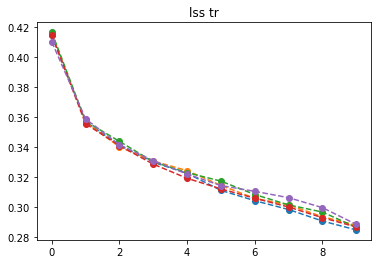

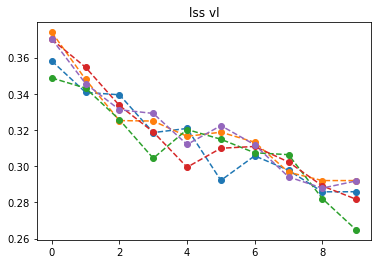

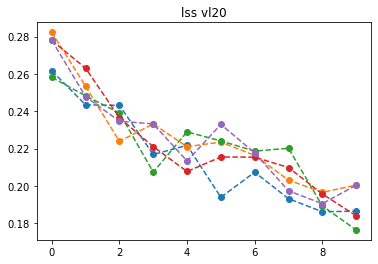

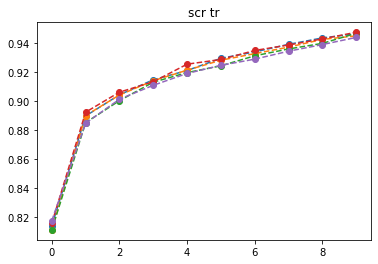

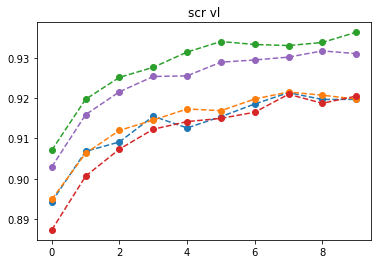

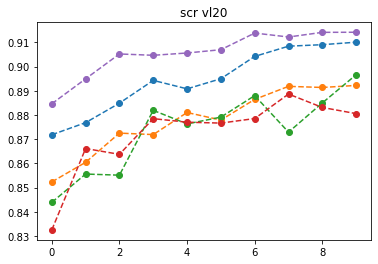

In [23]:
for mtrc in ['lss', 'scr']:
    for k in ['tr','vl','vl20']:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [24]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(58032, [0, 13, 16, 19, 27, 29, 31, 54, 55, 60])

## only last epoch 

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.9253600119130674

In [26]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.8966143795963073

## only best_scr epoch

In [27]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9260639598293186

In [28]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.8978922360854198

## only best_scr20 epoch

In [29]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc20']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9251147053129164

In [30]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.8977690159320791

## avg all epochs

In [31]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof.mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9245889065644112

In [32]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.8938724297653164

## avg last m epochs

In [33]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9273683742000138

In [34]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.8996523096477709

In [35]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [36]:
for m in range(1, 5):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.3f}', 
          f'{roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20]):.3f}')


1 0.925 0.897
2 0.927 0.899
3 0.927 0.900
4 0.927 0.899


## avg last m epochs before epo-q

In [37]:
def get_oof_avg_last_m_before_q(m,q):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, q-m:q].mean(1))
        oofs += list(oof)
    return oofs

In [38]:
for m in range(1, 5):
    oofs = get_oof_avg_last_m_before_q(m, 10)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.3f}', 
          f'{roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20]):.5f}')


1 0.925 0.89661
2 0.927 0.89907
3 0.927 0.89965
4 0.927 0.89901


# submissions

## only last epoch

In [39]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{param.EPOCHS-1}.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.17346020662848277


,image_name,target
0,ISIC_0052060,0.069580
1,ISIC_0052349,0.037517
2,ISIC_0058510,0.044390


fld 1 0.1786648778073212


,image_name,target
0,ISIC_0052060,0.087392
1,ISIC_0052349,0.105817
2,ISIC_0058510,0.080422


fld 2 0.15968566903578643


,image_name,target
0,ISIC_0052060,0.066578
1,ISIC_0052349,0.080563
2,ISIC_0058510,0.056799


fld 3 0.1602069836491073


,image_name,target
0,ISIC_0052060,0.081761
1,ISIC_0052349,0.064397
2,ISIC_0058510,0.044423


fld 4 0.18528199310580828


,image_name,target
0,ISIC_0052060,0.065375
1,ISIC_0052349,0.080051
2,ISIC_0058510,0.059156


0.1714599460453014


,image_name,target
0,ISIC_0052060,0.074137
1,ISIC_0052349,0.073669
2,ISIC_0058510,0.057038


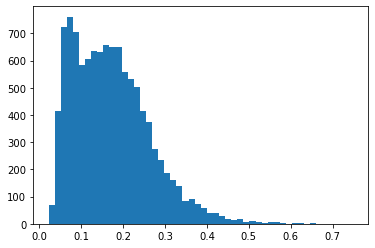

In [40]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [41]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlylast.csv', index=False)

## only best_scr epoch

In [42]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.18390420656583456


,image_name,target
0,ISIC_0052060,0.054681
1,ISIC_0052349,0.043810
2,ISIC_0058510,0.067237


fld 1 0.18796266675833093


,image_name,target
0,ISIC_0052060,0.086393
1,ISIC_0052349,0.127655
2,ISIC_0058510,0.088627


fld 2 0.15968566903578643


,image_name,target
0,ISIC_0052060,0.066578
1,ISIC_0052349,0.080563
2,ISIC_0058510,0.056799


fld 3 0.18814173083409125


,image_name,target
0,ISIC_0052060,0.084822
1,ISIC_0052349,0.075578
2,ISIC_0058510,0.060219


fld 4 0.17613408163822594


,image_name,target
0,ISIC_0052060,0.072637
1,ISIC_0052349,0.081421
2,ISIC_0058510,0.035181


0.1791656709664542


,image_name,target
0,ISIC_0052060,0.073022
1,ISIC_0052349,0.081805
2,ISIC_0058510,0.061613


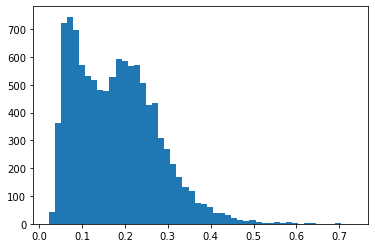

In [43]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [44]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr.csv', index=False)

## only best_scr20 epoch

In [45]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best20.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.17346020662848277


,image_name,target
0,ISIC_0052060,0.069580
1,ISIC_0052349,0.037517
2,ISIC_0058510,0.044390


fld 1 0.1786648778073212


,image_name,target
0,ISIC_0052060,0.087392
1,ISIC_0052349,0.105817
2,ISIC_0058510,0.080422


fld 2 0.15968566903578643


,image_name,target
0,ISIC_0052060,0.066578
1,ISIC_0052349,0.080563
2,ISIC_0058510,0.056799


fld 3 0.18814173083409125


,image_name,target
0,ISIC_0052060,0.084822
1,ISIC_0052349,0.075578
2,ISIC_0058510,0.060219


fld 4 0.18528199310580828


,image_name,target
0,ISIC_0052060,0.065375
1,ISIC_0052349,0.080051
2,ISIC_0058510,0.059156


0.17704689548229832


,image_name,target
0,ISIC_0052060,0.074749
1,ISIC_0052349,0.075905
2,ISIC_0058510,0.060197


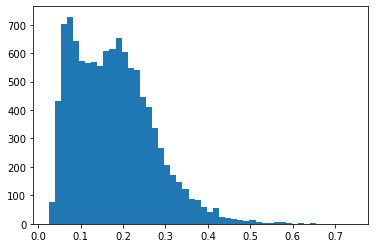

In [46]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [47]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr20.csv', index=False)

## avg last m epochs

In [48]:
m = 3

In [49]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-m, param.EPOCHS):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 7 0.18390420656583456


,image_name,target
0,ISIC_0052060,0.054681
1,ISIC_0052349,0.043810
2,ISIC_0058510,0.067237


fld 0 epc 8 0.17556590192369265


,image_name,target
0,ISIC_0052060,0.078603
1,ISIC_0052349,0.059064
2,ISIC_0058510,0.048318


fld 0 epc 9 0.17346020662848277


,image_name,target
0,ISIC_0052060,0.069580
1,ISIC_0052349,0.037517
2,ISIC_0058510,0.044390


fld 1 epc 7 0.18796266675833093


,image_name,target
0,ISIC_0052060,0.086393
1,ISIC_0052349,0.127655
2,ISIC_0058510,0.088627


fld 1 epc 8 0.18543153499908926


,image_name,target
0,ISIC_0052060,0.109711
1,ISIC_0052349,0.074787
2,ISIC_0058510,0.087498


fld 1 epc 9 0.1786648778073212


,image_name,target
0,ISIC_0052060,0.087392
1,ISIC_0052349,0.105817
2,ISIC_0058510,0.080422


fld 2 epc 7 0.20163083082835595


,image_name,target
0,ISIC_0052060,0.081290
1,ISIC_0052349,0.152985
2,ISIC_0058510,0.083718


fld 2 epc 8 0.17514327772322955


,image_name,target
0,ISIC_0052060,0.051961
1,ISIC_0052349,0.077612
2,ISIC_0058510,0.068759


fld 2 epc 9 0.15968566903578643


,image_name,target
0,ISIC_0052060,0.066578
1,ISIC_0052349,0.080563
2,ISIC_0058510,0.056799


fld 3 epc 7 0.18814173083409125


,image_name,target
0,ISIC_0052060,0.084822
1,ISIC_0052349,0.075578
2,ISIC_0058510,0.060219


fld 3 epc 8 0.17535881674822434


,image_name,target
0,ISIC_0052060,0.082236
1,ISIC_0052349,0.063083
2,ISIC_0058510,0.063837


fld 3 epc 9 0.1602069836491073


,image_name,target
0,ISIC_0052060,0.081761
1,ISIC_0052349,0.064397
2,ISIC_0058510,0.044423


fld 4 epc 7 0.1835571871727375


,image_name,target
0,ISIC_0052060,0.061686
1,ISIC_0052349,0.082309
2,ISIC_0058510,0.069365


fld 4 epc 8 0.17613408163822594


,image_name,target
0,ISIC_0052060,0.072637
1,ISIC_0052349,0.081421
2,ISIC_0058510,0.035181


fld 4 epc 9 0.18528199310580828


,image_name,target
0,ISIC_0052060,0.065375
1,ISIC_0052349,0.080051
2,ISIC_0058510,0.059156


0.17934199769455472


,image_name,target
0,ISIC_0052060,0.075647
1,ISIC_0052349,0.080443
2,ISIC_0058510,0.063863


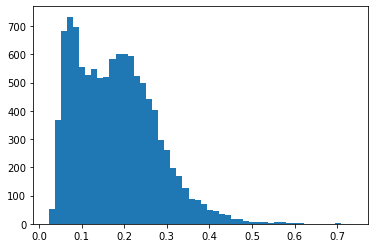

In [50]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [51]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

## avg last m epochs before epo-q

In [54]:
m = 2
q = 8

In [55]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(q-m, q):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 6 0.19359267327927446


,image_name,target
0,ISIC_0052060,0.071659
1,ISIC_0052349,0.089034
2,ISIC_0058510,0.053034


fld 0 epc 7 0.18390420656583456


,image_name,target
0,ISIC_0052060,0.054681
1,ISIC_0052349,0.043810
2,ISIC_0058510,0.067237


fld 1 epc 6 0.20138933387543193


,image_name,target
0,ISIC_0052060,0.107874
1,ISIC_0052349,0.103124
2,ISIC_0058510,0.083737


fld 1 epc 7 0.18796266675833093


,image_name,target
0,ISIC_0052060,0.086393
1,ISIC_0052349,0.127655
2,ISIC_0058510,0.088627


fld 2 epc 6 0.19966089139801463


,image_name,target
0,ISIC_0052060,0.101812
1,ISIC_0052349,0.156382
2,ISIC_0058510,0.074915


fld 2 epc 7 0.20163083082835595


,image_name,target
0,ISIC_0052060,0.081290
1,ISIC_0052349,0.152985
2,ISIC_0058510,0.083718


fld 3 epc 6 0.19185631012748197


,image_name,target
0,ISIC_0052060,0.122865
1,ISIC_0052349,0.082177
2,ISIC_0058510,0.076670


fld 3 epc 7 0.18814173083409125


,image_name,target
0,ISIC_0052060,0.084822
1,ISIC_0052349,0.075578
2,ISIC_0058510,0.060219


fld 4 epc 6 0.20244984345629177


,image_name,target
0,ISIC_0052060,0.080665
1,ISIC_0052349,0.108689
2,ISIC_0058510,0.078061


fld 4 epc 7 0.1835571871727375


,image_name,target
0,ISIC_0052060,0.061686
1,ISIC_0052349,0.082309
2,ISIC_0058510,0.069365


0.1934145674295848


,image_name,target
0,ISIC_0052060,0.085375
1,ISIC_0052349,0.102174
2,ISIC_0058510,0.073558


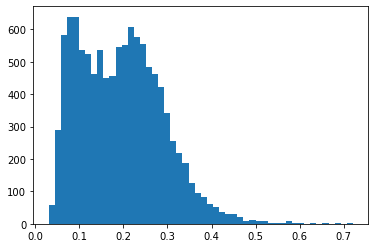

In [57]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [58]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_{m}before{q}.csv', index=False)

# fin

In [65]:
for fld,stats in results['fld2stats'].items():
    print(f"best_scr: {stats['best_scr']:.3f}; best_epc: {stats['best_epc']}; best_scr20: {stats['best_scr20']:.3f}; best_epc20: {stats['best_epc20']}")

best_scr: 0.921; best_epc: 7; best_scr20: 0.910; best_epc20: 9
best_scr: 0.922; best_epc: 7; best_scr20: 0.892; best_epc20: 9
best_scr: 0.936; best_epc: 9; best_scr20: 0.897; best_epc20: 9
best_scr: 0.921; best_epc: 7; best_scr20: 0.889; best_epc20: 7
best_scr: 0.932; best_epc: 8; best_scr20: 0.914; best_epc20: 9


In [62]:
param.__dict__

{'PRFX': 'Mel0713B1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909A224',
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'EPOCHS': 10,
 'BS': 72,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 20,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [60]:
!nvidia-smi

Tue Jul 14 20:21:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   54C    P0    60W / 300W |  15827MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  